In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd
import datashader as ds

In [3]:
from moonbow.style import register_cmaps
register_cmaps()

In [19]:
from moonbow.style import make_moonbow
moonbow_cmap = make_moonbow()

In [4]:
from glcat_lightcurve_utils import counts2mag

In [5]:
ncat = pd.read_csv('ncat_240616.csv',index_col=None)

In [8]:
models = pd.read_csv('ncat_nuv_fit_240616.csv',index_col=None)
models.keys()

Index(['cps', 'cps_lower_conf', 'cps_upper_conf', 'sigma', 'sigma_lower_conf',
       'sigma_upper_conf', 'bg_cps', 'bg_cps_lower_conf', 'bg_cps_upper_conf',
       'bg_cps_annulus'],
      dtype='object')

In [9]:
aperture_radii = np.array([1.5 , 2.3 , 3.8 , 6.0 , 9.0 , 12.8, 17.3])
aperture_corr  = np.array([2.09, 1.33, 0.59, 0.23, 0.13, 0.09, 0.07])

In [10]:
def gaussian_flux_model(theta, r):
    total_flux, sigma, background = theta
    return total_flux * (1 - np.exp(-r**2 / (2 * sigma**2))) + background * np.pi * r**2

Text(0.5, 0, 'fwhm')

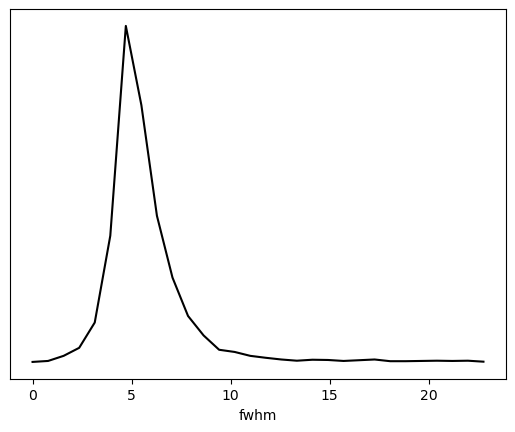

In [11]:
bins,vals = np.histogram(models['sigma']*2.355,bins=30,range=[0,10*2.355])
plt.plot(vals[:-1],bins,'k-')
plt.yticks([])
plt.xlabel('fwhm')

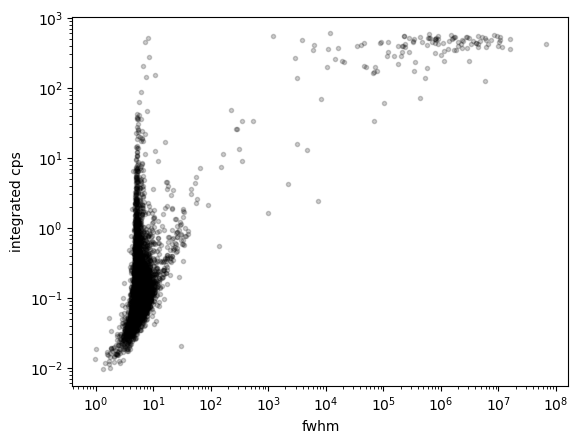

In [12]:
plt.errorbar(models['sigma']*2.355,models['cps'],fmt='k.',alpha=0.2)
plt.ylabel('integrated cps')
plt.xlabel('fwhm')
plt.loglog();

(1, 40)

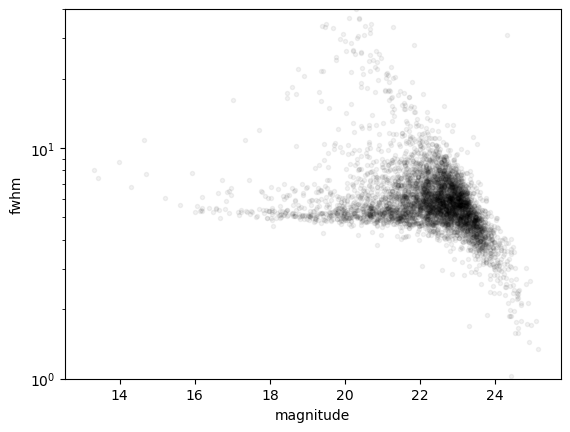

In [25]:
plt.errorbar(counts2mag(models['cps'],'NUV'),models['sigma']*2.355,fmt='k.',alpha=0.05)
plt.xlabel('magnitude')
plt.ylabel('fwhm')
plt.semilogy();
plt.ylim([1,40])

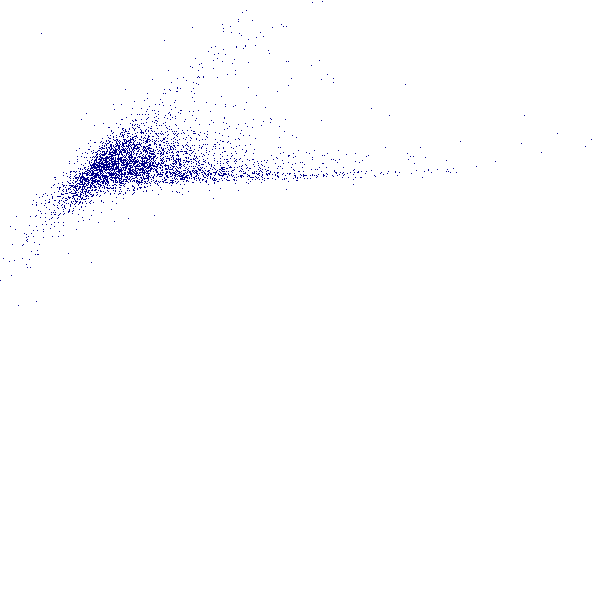

In [21]:
ds.tf.shade(ds.Canvas(y_range=(0.01,20),y_axis_type='log',x_axis_type='log').
      points(models,'cps','sigma',agg=ds.any()),)
#           cmap=moonbow_cmap)

(0.001, 0.005)

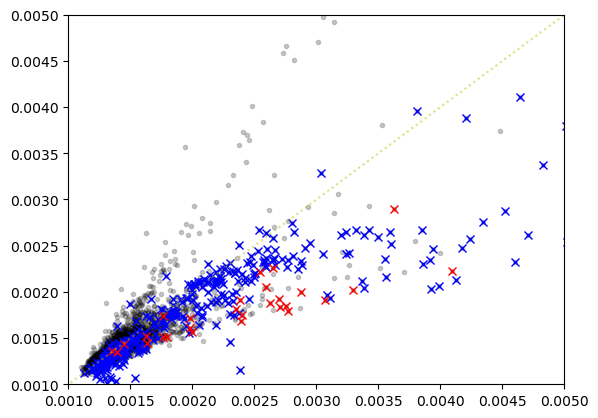

In [15]:
bix = np.where(models['sigma']>4)
rix = np.where(models['sigma']<1)
plt.plot(models['bg_cps_annulus'],models['bg_cps'],'k.',alpha=0.2)
plt.plot(models['bg_cps_annulus'].values[bix],models['bg_cps'].values[bix],'bx',alpha=1)
plt.plot(models['bg_cps_annulus'].values[rix],models['bg_cps'].values[rix],'rx',alpha=1)
plt.plot([0,500],[0,500],'y:',alpha=0.5)
plt.xlim([0.001,0.005])
plt.ylim([0.001,0.005])

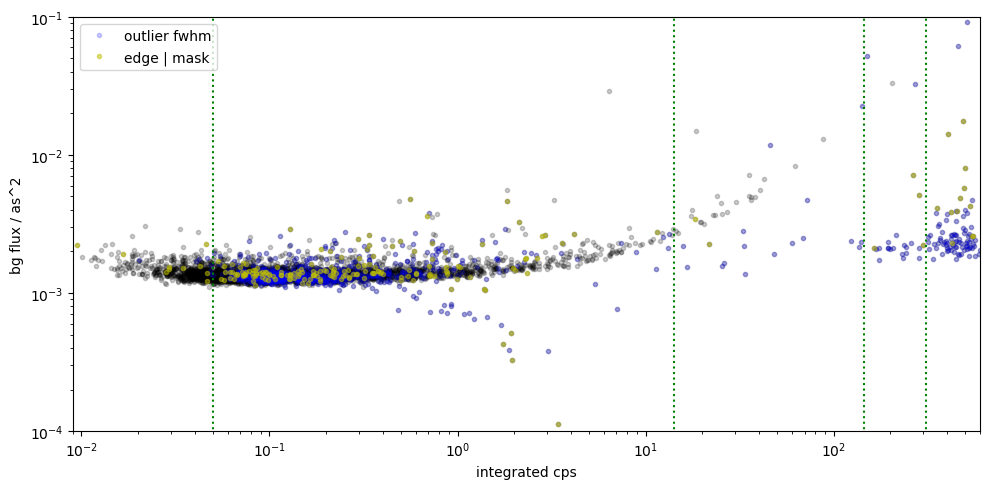

In [10]:
plt.figure(figsize=(10,5))
rix = np.where(ncat['NUV_EDGE_APER6'].values | ncat['NUV_MASK_APER6'].values)
bix = np.where(models['sigma']>3)
plt.plot(models['cps'],models['bg_cps'],'k.',alpha=0.2)
plt.plot(models['cps'].values[bix],models['bg_cps'].values[bix],'b.',alpha=0.2,label='outlier fwhm')
plt.plot(models['cps'].values[rix],models['bg_cps'].values[rix],'y.',alpha=0.5,label='edge | mask')
plt.xlabel('integrated cps')
plt.ylabel('bg flux / as^2')
plt.vlines([0.05,14.1,145,311],0,100,colors='g',linestyles='dotted')
plt.xlim([0.009,600])
plt.ylim([10**-4,10**-1])
plt.legend()
plt.loglog()
plt.tight_layout()

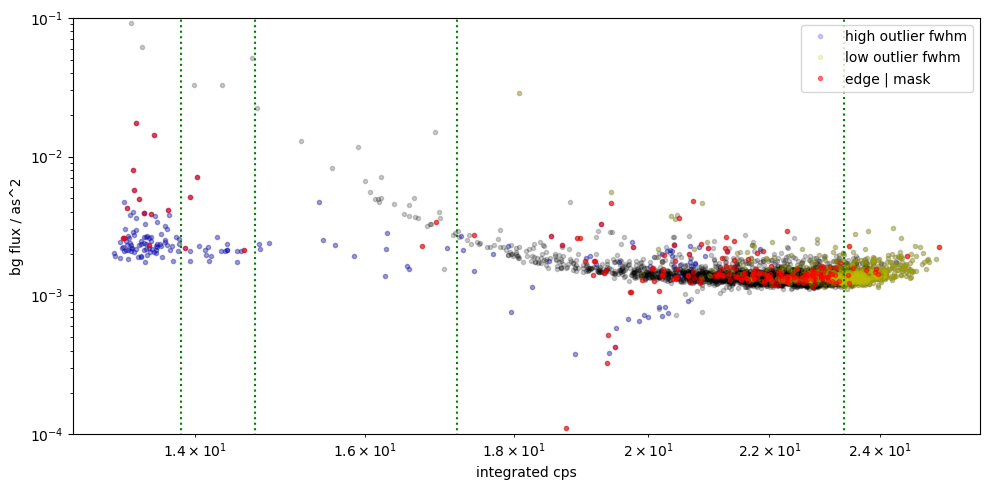

In [158]:
plt.figure(figsize=(10,5))
rix = np.where(ncat['NUV_EDGE_APER6'].values | ncat['NUV_MASK_APER6'].values)
bix = np.where(models['sigma']>10)
yix = np.where(models['sigma']<2)
plt.plot(counts2mag(models['cps'],'NUV'),models['bg_cps'],'k.',alpha=0.2)
plt.plot(counts2mag(models['cps'],'NUV').values[bix],models['bg_cps'].values[bix],'b.',alpha=0.2,label='high outlier fwhm')
plt.plot(counts2mag(models['cps'],'NUV').values[yix],models['bg_cps'].values[yix],'y.',alpha=0.2,label='low outlier fwhm')
plt.plot(counts2mag(models['cps'],'NUV').values[rix],models['bg_cps'].values[rix],'r.',alpha=0.5,label='edge | mask')
plt.xlabel('integrated cps')
plt.ylabel('bg flux / as^2')
plt.vlines(counts2mag([0.05,14.1,145,311],'NUV'),0,100,colors='g',linestyles='dotted')
#plt.xlim([0.009,600])
plt.ylim([10**-4,10**-1])
plt.legend()
plt.loglog()
plt.tight_layout()

In [13]:
min(models['cps']),max(models['cps'])

(0.0094942546692736, 599.0699897997481)

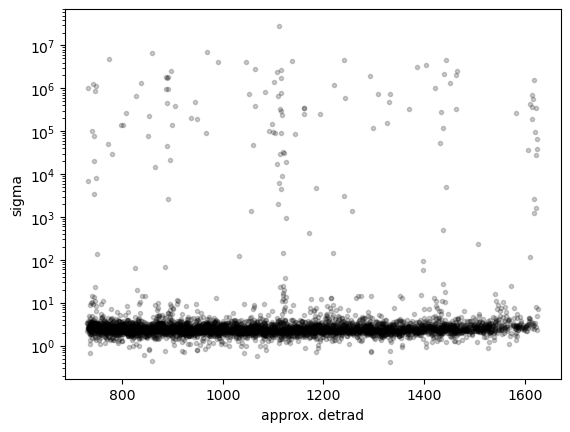

In [14]:
x,y = ncat['NUV_XCENTER'].max()/2,ncat['NUV_YCENTER']
detrad = np.sqrt((x-x/2)**2+(y-y/2)**2)
plt.figure()
plt.plot(detrad,models['sigma'],'k.',alpha=0.2)
plt.xlabel('approx. detrad')
plt.ylabel('sigma')
plt.semilogy();

[]

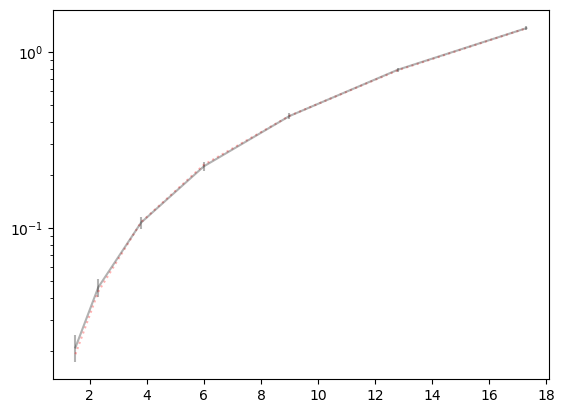

In [161]:
i = 100
flux = np.array([ncat[f'NUV_CPS_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
flux_err = np.array([ncat[f'NUV_CPS_ERR_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
plt.errorbar(aperture_radii,flux,yerr=flux_err,fmt='k-',alpha=0.3)
plt.plot(aperture_radii,gaussian_flux_model(
    (models['cps'].iloc[i],models['sigma'].iloc[i],models['bg_cps'].iloc[i]),
     aperture_radii),
    'r:',alpha=0.3)
plt.semilogy()

In [55]:
def gaussian_flux_fraction(r, sigma):
    return 1 - np.exp(-r**2 / (2 * sigma**2))

In [72]:
flux = gaussian_flux_model(
    (models['cps'].iloc[i],models['sigma'].iloc[i],models['bg_cps'].iloc[i]),
     aperture_radii)
aperture_scale_correction = gaussian_flux_fraction(aperture_radii,models['sigma'].iloc[i])
print(flux)
print(flux/aperture_scale_correction)

[0.01914806 0.04342966 0.10777988 0.22855371 0.43364543 0.78803261
 1.36493473]
[0.18070361 0.18758166 0.21022527 0.27424323 0.44147407 0.78825879
 1.3649352 ]


In [69]:
bg= models['bg_cps'].iloc[i]*np.pi*np.array(aperture_radii)**2
counts2mag(bg,'NUV')

array([25.12628457, 24.19810169, 23.10782288, 22.11598461, 21.23552832,
       20.47069102, 19.81651035])

In [63]:
(flux-bg)/aperture_scale_correction

array([0.09027035, 0.09027035, 0.09027035, 0.09027035, 0.09027035,
       0.09027035, 0.09027035])

In [75]:
bg/flux

array([0.50045073, 0.51876769, 0.57060179, 0.67083835, 0.79552513,
       0.88548132, 0.93386473])

In [66]:
counts2mag(0.09027035,'NUV')

22.691137184180374

In [71]:
models['cps'].iloc[i]*aperture_scale_correction

array([0.0095654 , 0.02089975, 0.04628049, 0.07523112, 0.08866959,
       0.09024445, 0.09027032])

In [73]:
bg

array([0.00958266, 0.0225299 , 0.0614994 , 0.15332259, 0.34497583,
       0.69778816, 1.27466441])

In [101]:
cps = np.array([ncat[f'NUV_CPS_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
cps

array([0.02091576, 0.04598121, 0.10725031, 0.22404212, 0.43271667,
       0.79352705, 1.36719543])

In [98]:
list(np.round(2.5 * np.log10(1/gaussian_flux_fraction(aperture_radii,5/2.355)),2))

[1.64, 0.88, 0.24, 0.02, 0.0, 0.0, 0.0]

In [99]:
[2.09, 1.33, 0.59, 0.23, 0.13, 0.09, 0.07]
[1.33, 0.62, 0.21, 0.12, 0.08, 0.06, 0.04]

[1.33, 0.62, 0.21, 0.12, 0.08, 0.06, 0.04]

In [104]:
counts2mag((cps-bg)/aperture_scale_correction,'NUV')

array([22.507023  , 22.56607235, 22.70363256, 22.75828251, 22.70256947,
       22.62696743, 22.66428129])

In [109]:
counts2mag((flux-bg)/aperture_scale_correction,'NUV')

array([22.69113713, 22.69113713, 22.69113713, 22.69113713, 22.69113713,
       22.69113713, 22.69113713])

In [107]:
counts2mag(cps-bg,'NUV')-np.array([2.09, 1.33, 0.59, 0.23, 0.13, 0.09, 0.07])

array([22.85412793, 22.82458227, 22.83900059, 22.72615162, 22.59199556,
       22.53727901, 22.59428166])

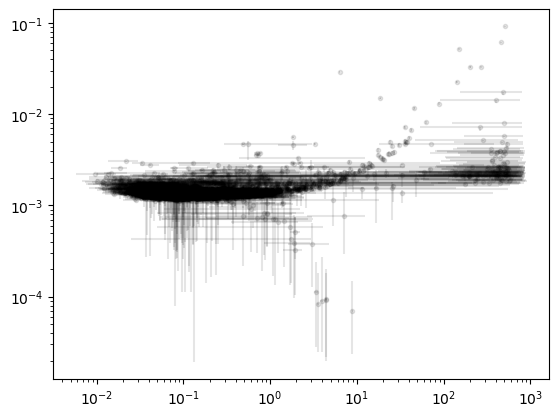

In [118]:
plt.errorbar(models['cps'],models['bg_cps'],
             xerr=[models['cps_lower_conf'],models['cps_upper_conf']],
             yerr=[models['bg_cps_lower_conf'],models['bg_cps_upper_conf']],
             fmt='k.',alpha=0.1)
plt.loglog();

(0.0, 10.0)

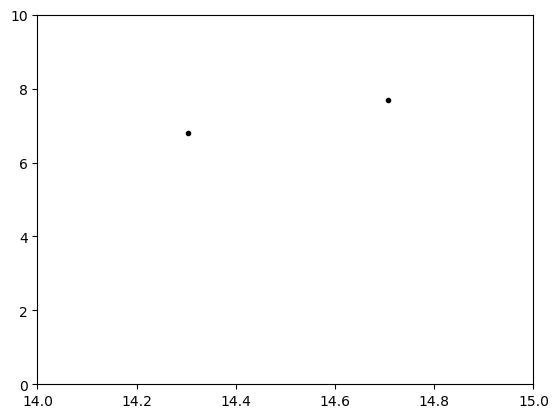

In [130]:
plt.plot(counts2mag(models['cps'],'NUV'),models['sigma']*2.355,'k.')
plt.xlim([14,15])
plt.ylim([0,10])

In [129]:
for n in np.arange(5,10,0.1):
    print(n,list(np.round(2.5 * np.log10(1/gaussian_flux_fraction(aperture_radii,n/2.355)),2)))

5.0 [1.64, 0.88, 0.24, 0.02, 0.0, 0.0, 0.0]
5.1 [1.68, 0.91, 0.26, 0.02, 0.0, 0.0, 0.0]
5.199999999999999 [1.72, 0.95, 0.28, 0.03, 0.0, 0.0, 0.0]
5.299999999999999 [1.75, 0.98, 0.3, 0.03, 0.0, 0.0, 0.0]
5.399999999999999 [1.79, 1.01, 0.32, 0.04, 0.0, 0.0, 0.0]
5.499999999999998 [1.82, 1.04, 0.34, 0.04, 0.0, 0.0, 0.0]
5.599999999999998 [1.86, 1.07, 0.36, 0.05, 0.0, 0.0, 0.0]
5.6999999999999975 [1.89, 1.1, 0.37, 0.05, 0.0, 0.0, 0.0]
5.799999999999997 [1.93, 1.13, 0.39, 0.06, 0.0, 0.0, 0.0]
5.899999999999997 [1.96, 1.16, 0.41, 0.06, 0.0, 0.0, 0.0]
5.9999999999999964 [2.0, 1.19, 0.43, 0.07, 0.0, 0.0, 0.0]
6.099999999999996 [2.03, 1.22, 0.45, 0.08, 0.0, 0.0, 0.0]
6.199999999999996 [2.06, 1.25, 0.47, 0.08, 0.0, 0.0, 0.0]
6.299999999999995 [2.09, 1.28, 0.49, 0.09, 0.0, 0.0, 0.0]
6.399999999999995 [2.12, 1.3, 0.51, 0.1, 0.0, 0.0, 0.0]
6.499999999999995 [2.16, 1.33, 0.53, 0.11, 0.01, 0.0, 0.0]
6.599999999999994 [2.19, 1.36, 0.55, 0.12, 0.01, 0.0, 0.0]
6.699999999999994 [2.22, 1.39, 0.57, 0.12, 

In [136]:
ix = np.where(counts2mag(models['cps'],'NUV')<15)
models['sigma_lower_conf'].iloc[ix].values

array([5.85620496e+03, 7.55983414e+05, 9.34050431e+04, 9.53610765e+05,
       1.71364122e+04, 8.05304607e+03, 9.49624974e+05, 4.59493025e+04,
       4.29318245e+06, 2.99252033e+04, 1.20242578e+05, 1.30981832e+05,
       1.91182336e+05, 4.41069987e-03, 5.17275825e+05, 9.36428741e+05,
       6.02912490e+04, 1.80164413e+05, 5.36073791e+06, 1.41730083e+04,
       1.41946414e+06, 8.20759493e+05, 1.21062567e+06, 3.48717999e+05,
       2.34509722e+03, 7.33471679e+05, 1.40661808e+06, 2.13324897e+04,
       1.85032370e+06, 1.19533929e+05, 2.68158005e+05, 1.50120226e+05,
       4.83124893e+05, 6.65027748e+04, 5.14281276e+06, 3.22037574e+06,
       3.34357475e+06, 5.84532209e+05, 1.25937863e+03, 4.85031443e+04,
       3.21856969e+05, 2.69508227e+06, 8.21666768e+05, 5.89522132e-03,
       8.85858428e+04, 1.45885215e+05, 8.20895566e+04, 1.14298401e+06,
       6.44881059e+04, 2.26685177e+06, 1.66615279e+04, 5.38153828e+05,
       6.06807319e+03, 2.57540738e+05, 8.91855165e+04, 4.33637871e+03,
      